## Exploring the SARIMA model with python

Credits: https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d

## Load Data

In [1]:
# Import modules
# Read data
import os
import sys
import pickle

# Dataframes
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import concat
# display and formatting
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

# Config
folder = './data/'
file = 'train_6BJx641.csv'


def _ReadCsv_pd(datafolder, file):
    """Read CSV file from remote path.
    Returns:
      The contents of CSV file.
    Raises:
      ValueError: Unable to read file
    """
    try:
        df = pd.read_csv(os.path.join(datafolder, file))
        print(file, ": Read csv to dataframe sucessfully")
        print("Shape of dataframe", df.shape, "Memory Usage", sys.getsizeof(df))
    except Exception as e:
        raise type(e)(e)
        exit()
    return(df)

df = _ReadCsv_pd(folder, file)
df_copy = df.copy()

def __GetTimeSeriesCount(df, col_name):
    try:
        print(pd.concat(g for _, g in df.groupby() if len(g) > 1))
        
    except:
        print("Dataframe is single timeseries")
    return()

__GetTimeSeriesCount(df,"datetime")

df.head()

train_6BJx641.csv : Read csv to dataframe sucessfully
Shape of dataframe (26496, 8) Memory Usage 5034400
Dataframe is single timeseries


,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.40,-17.10,1003.00,571.91,A,216.00
1,1,2013-07-01 01:00:00,-12.10,-19.30,996.00,575.04,A,210.00
2,2,2013-07-01 02:00:00,-12.90,-20.00,1000.00,578.43,A,225.00
3,3,2013-07-01 03:00:00,-11.40,-17.10,995.00,582.58,A,216.00
4,4,2013-07-01 04:00:00,-11.40,-19.30,1005.00,586.60,A,222.00


## Pre-Process Data

In [2]:
def __GetIntCols(df, collist):
    for col in collist:
        df[col] = df[col].str.extract('(\d+)').astype(float)
    return(df)

def get_prop_missing_values(df):
    print("Null info in data: ", df.isna().any().sum())
    #prop_missing = round((df[df.columns[:]].isnull().sum()/df[df.columns[:]].count())*100,4)
    prop_missing = round((df.isnull().sum()/len(df))*100,2)
    print("These are the missing values proportions in each column")
    print(prop_missing)
    return()


def __SetColumnTypes(df, change_to_int_list = ['col1']):
    cols = df.columns
    try:
        df = __GetIntCols(df, change_to_int_list)
    except:
        pass
    # Check for any null values in the data
    print("% Missing data in each column \n",get_prop_missing_values(df))
    return(df, cols)


# For this particular dataframe
df['datetime'] = pd.to_datetime(df['datetime'])
clean_df, cols = __SetColumnTypes(df)

# Get list of column by types
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(cols) - set(num_cols))
cat_cols.remove('datetime')
print(cat_cols)

Null info in data:  0
These are the missing values proportions in each column
ID                        0.00
datetime                  0.00
temperature               0.00
var1                      0.00
pressure                  0.00
windspeed                 0.00
var2                      0.00
electricity_consumption   0.00
dtype: float64
% Missing data in each column 
 ()
['var2']


## Split Train Test and Explore

Min date train main 2013-07-01 00:00:00 Max date train main 2016-09-10 03:00:00
Min date test main 2016-09-10 04:00:00 Max date test main 2017-06-23 23:00:00
Length of train 21196 Length of test 5300
Plot 1: Simple scatter plot of feature1 and feature2
Plot 2: Scatter plot of feature1 and feature2 with density feature
Plot 3: Scatter plot with df; target as color
Corr with original set of features
electricity_consumption    1.00
var1                       0.14
ID                         0.05
pressure                  -0.01
temperature               -0.11
windspeed                 -0.25
Name: electricity_consumption, dtype: float64
Corr with addition of new features
electricity_consumption      1.00
var1                         0.14
windspeed_per_var1           0.07
ID                           0.05
pressure                    -0.01
pressure_per_temperature    -0.06
temperature                 -0.11
temperature_per_windspeed   -0.11
windspeed                   -0.25
Name: electricity_co

,ID,ds,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.40,-17.10,1003.00,571.91,A,216.00
1,1,2013-07-01 01:00:00,-12.10,-19.30,996.00,575.04,A,210.00
2,2,2013-07-01 02:00:00,-12.90,-20.00,1000.00,578.43,A,225.00


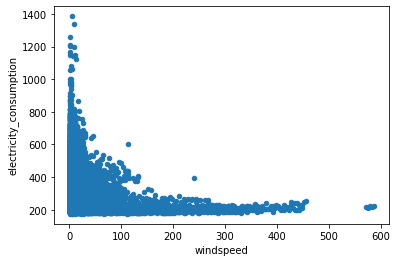

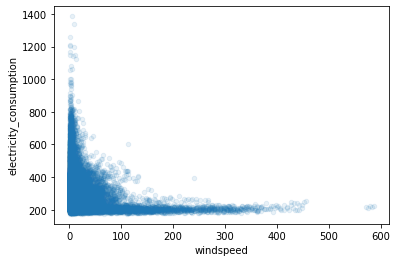

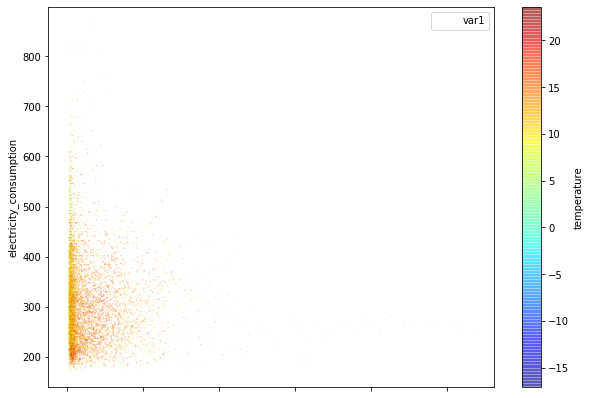

In [3]:
# Helper functions
# Split dataframe
def __SplitTrainTest(X, prop = 0.95):
    '''Takes in the dataframe and proprtion of train size and returns the train and test sets'''
    X.sort_values(by='ds', ascending=True, inplace = True)
    train_size = int(len(X) * prop)
    train, test = X[0:train_size], X[train_size:len(X)]
    print("Min date train main", train.ds.min(), "Max date train main", train.ds.max())
    print("Min date test main", test.ds.min(), "Max date test main", test.ds.max())
    print("Length of train", len(train), "Length of test", len(test))
    return(train, test)

clean_df.rename(columns={'datetime': 'ds'}, inplace=True)
train_df, test_df = __SplitTrainTest(clean_df, prop = 0.80)

# Step 5: Put the test set aside



def __SimpleScatterPlots(df, feature1, feature2, feature3, target):
    try:
        print("Plot 1: Simple scatter plot of feature1 and feature2")
        df.plot(kind='scatter', x=feature1, y=feature2)

        # Using density to see which areas are densly populated
        print("Plot 2: Scatter plot of feature1 and feature2 with density feature")
        df.plot(kind='scatter', x=feature1, y=feature2, alpha = 0.1)

        # Adding more variable features to map color of circle (price) and size of circle (population)

        print("Plot 3: Scatter plot with df; target as color")
        df.plot(kind='scatter', x=feature1, y=feature2, alpha = 0.4,
                    s= df[feature3]/100, label= feature3, figsize = (10,7),
                    c= target, cmap = plt.get_cmap("jet"), colorbar= True
                    )
        plt.legend()
    except:
        pass
    return()

__SimpleScatterPlots(train_df, 'windspeed', 'electricity_consumption', 'var1', 'temperature')

# Correlation with target variable
corr_matrix = train_df.corr()
print("Corr with original set of features")
print(corr_matrix["electricity_consumption"].sort_values(ascending=False))

train_df["windspeed_per_var1"] = train_df["windspeed"]/train_df["var1"]
train_df["pressure_per_temperature"] = train_df["pressure"]/train_df["temperature"]
train_df["temperature_per_windspeed"] = train_df["temperature"]/train_df["windspeed"]

# Correlation with target variable
corr_matrix = train_df.corr()
print("Corr with addition of new features")
print(corr_matrix["electricity_consumption"].sort_values(ascending=False))

print("Dropping the new features at this point")
drop_cols = ['windspeed_per_var1', 'pressure_per_temperature', 'temperature_per_windspeed']
train_df.drop(drop_cols, axis = 1, inplace = True)
train_df.head(3)

## Prepare Modeling Data

In [4]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [5]:
# Get a clean train dataset with separate label
 

def __Transform(dfx):
    try:
        model_labels = dfx["electricity_consumption"].copy()
        dfx = dfx.drop(["electricity_consumption"], axis = 1)
    except:
        pass
    model_id = dfx["ID"].copy()
    model_ds = dfx["ds"].copy()
    model_df = dfx.drop(["ID","ds"], axis = 1)

    # Convert categorical variables to numeric - one hot encoder

    from sklearn.preprocessing import OneHotEncoder


    cat_encoder = OneHotEncoder()
    model_cat = model_df[cat_cols]
    model_cat_1hot = cat_encoder.fit_transform(model_cat)
    # model_cat_1hot.toarray()

#     print(cat_encoder.categories_)


    # Scale numeric
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler

    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])


    model_num = model_df.drop(cat_cols, axis = 1)
    model_num_tr = num_pipeline.fit_transform(model_num)


    from sklearn.compose import ColumnTransformer

    num_attribs = list(model_num)
    cat_attribs = cat_cols

    full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs)
    ])


    model_prepared = full_pipeline.fit_transform(model_df)

    trans_df = pd.DataFrame(
        model_prepared,
        columns=['temperature','var1','pressure','windspeed','A','B','C'])


    # trans_df["ID"] = model_id
    trans_df["ds"] = list(model_ds)
    def __SetDsIndex(df):
        df['ds'] = pd.to_datetime(df['ds'])
        df = df.set_index('ds')
        df['ds'] = pd.to_datetime(df.index)
        return(df)
    trans_df = __SetDsIndex(trans_df)
    trans_df['ID'] = list(model_id)
    try:
        trans_df["electricity_consumption"] = list(model_labels)
        trans_df = trans_df[['ID' ,'ds','temperature', 'var1','pressure','windspeed','A','B','C','electricity_consumption']]
        trans_df.rename(columns={'electricity_consumption': 'y'}, inplace=True)
    except:
        trans_df = trans_df[['ID' ,'ds','temperature', 'var1','pressure','windspeed','A','B','C']]
    def date_features(df,date_col):
        '''Returns dataframe with date features on date column given'''
        df['ds'] = pd.to_datetime(df[date_col])
        df['d_hour'] = df.ds.dt.hour
        df['d_month'] = df.ds.dt.month
        df['d_dayofyear'] = df.ds.dt.dayofyear
        df['d_weeknum'] = df.ds.dt.week
        df['d_weekday'] = df.ds.dt.weekday
        df['d_weekend'] = np.where(df['d_weekday']<5,0,1)
        return(df)
    trans_df = date_features(trans_df,'ds')
    print("Returned transformed df")
    return(trans_df)


In [6]:
tr_df = __Transform(train_df)
ts_df = __Transform(test_df)

Returned transformed df
Returned transformed df


In [7]:
tr_df.head()

,ID,ds,temperature,var1,pressure,windspeed,A,B,C,y,d_hour,d_month,d_dayofyear,d_weeknum,d_weekday,d_weekend
ds,,,,,,,,,,,,,,,,
2013-07-01 00:00:00,0,2013-07-01 00:00:00,-1.78,-1.37,1.31,11.18,1.00,0.00,0.00,216.00,0,7,182,27,0,0
2013-07-01 01:00:00,1,2013-07-01 01:00:00,-1.86,-1.57,0.73,11.24,1.00,0.00,0.00,210.00,1,7,182,27,0,0
2013-07-01 02:00:00,2,2013-07-01 02:00:00,-1.95,-1.64,1.06,11.31,1.00,0.00,0.00,225.00,2,7,182,27,0,0
2013-07-01 03:00:00,3,2013-07-01 03:00:00,-1.78,-1.37,0.65,11.40,1.00,0.00,0.00,216.00,3,7,182,27,0,0
2013-07-01 04:00:00,4,2013-07-01 04:00:00,-1.78,-1.57,1.47,11.48,1.00,0.00,0.00,222.00,4,7,182,27,0,0


In [9]:
import warnings
import itertools

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [12]:
tr_df1 = tr_df[['ds','y']]
ts_df1 = ts_df[['ds','y']]
tr_df1.rename(columns={'y': 'target'}, inplace=True)
ts_df1.rename(columns={'y': 'target'}, inplace=True)

In [13]:
y = tr_df1.set_index(['ds'])
y.head(5)

,target
ds,
2013-07-01 00:00:00,216.00
2013-07-01 01:00:00,210.00
2013-07-01 02:00:00,225.00
2013-07-01 03:00:00,216.00
2013-07-01 04:00:00,222.00


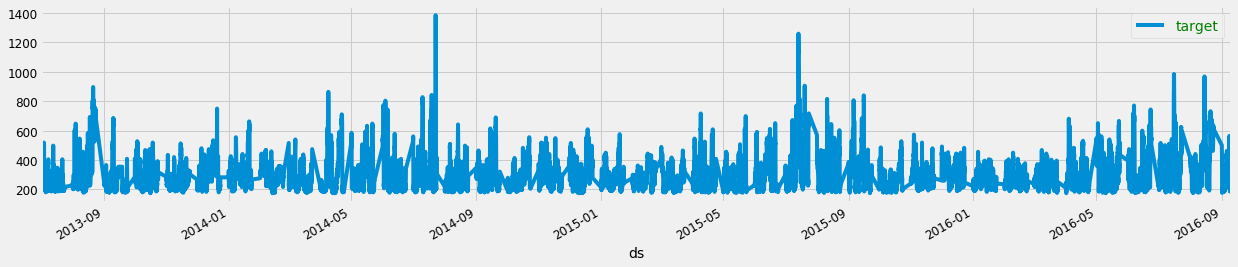

In [14]:
y.plot(figsize=(19, 4))
plt.show()

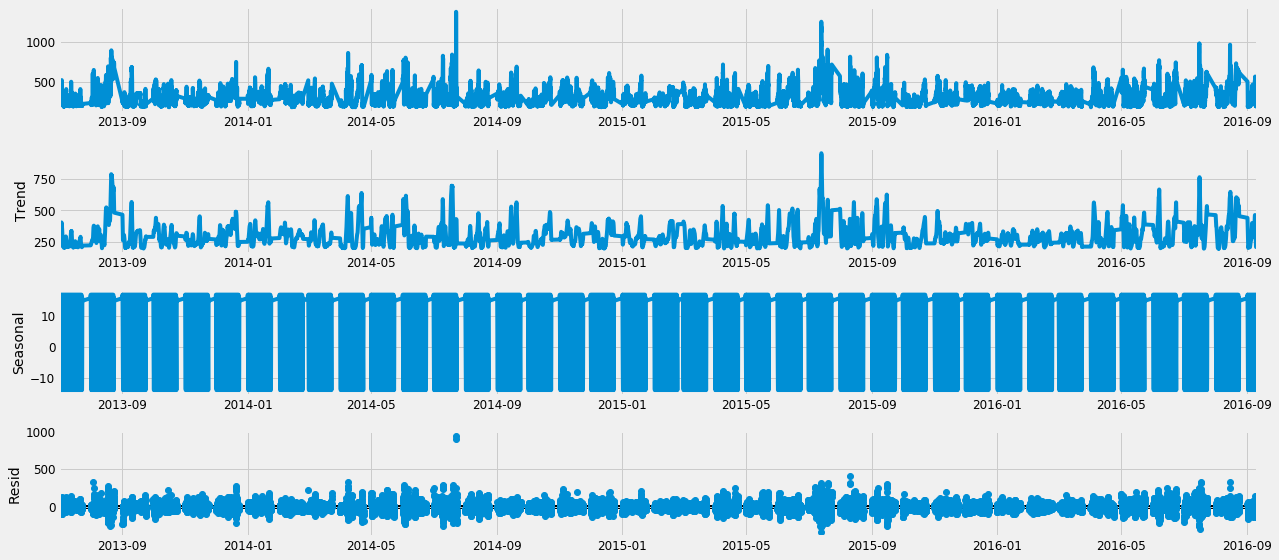

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive', freq = 24)
fig = decomposition.plot()
plt.show()

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:304864.4948570498
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:286934.25350994256
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:257889.97035941787
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:254980.22304759064
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:257314.101836448
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:254945.7564371642
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:255672.2596331024
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:252286.3934929253
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:278350.598235284
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:262400.2379298535
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:239776.97372166277
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:235596.22347338343
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:239015.83010739635
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:235588.6621759711
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:236892.28643154397
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:233145.44661738953
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:208647.5038582472
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:208527.79674325025
ARI

In [19]:
# ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:207901.25599490618

In [20]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9501      0.001    855.444      0.000       0.948       0.952
ma.L1          0.0578      0.003     17.363      0.000       0.051       0.064
ma.S.L12      -1.0000      0.146     -6.838      0.000      -1.287      -0.713
sigma2      1073.2589    156.993      6.836      0.000     765.559    1380.959


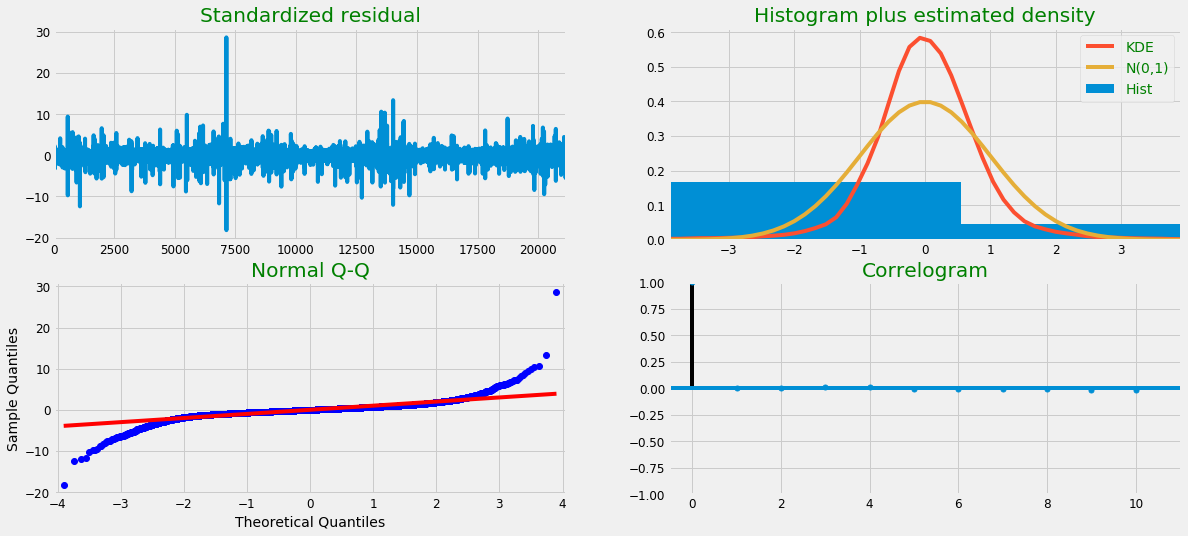

In [21]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [25]:
tr_df1.tail()

,ds,target
ds,,
2016-09-09 23:00:00,2016-09-09 23:00:00,264.00
2016-09-10 00:00:00,2016-09-10 00:00:00,231.00
2016-09-10 01:00:00,2016-09-10 01:00:00,222.00
2016-09-10 02:00:00,2016-09-10 02:00:00,225.00
2016-09-10 03:00:00,2016-09-10 03:00:00,201.00


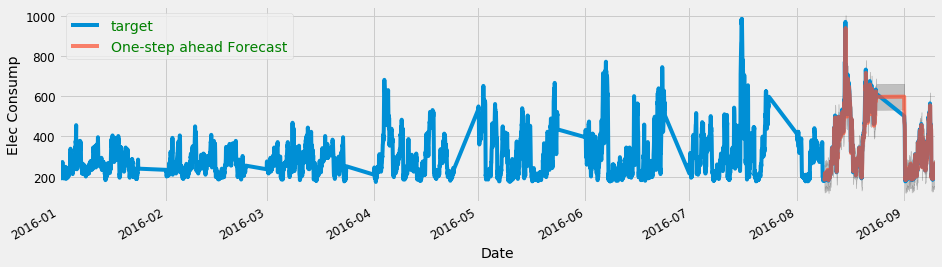

In [27]:
pred = results.get_prediction(start=pd.to_datetime('2016-08-08 23:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Elec Consump')
plt.legend()
plt.show()

In [38]:
y_forecasted = pred.predicted_mean
y_forecasted = pd.DataFrame(y_forecasted)
y_forecasted.columns = ['target']
y_truth = y['2016-08-08 23:00:00':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is target   1170.85
dtype: float64
The Root Mean Squared Error is target   34.22
dtype: float64


In [39]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Elec Consump')
plt.legend()
plt.show()

ValueError: year 0 is out of range

ValueError: year 0 is out of range

<Figure size 1008x288 with 1 Axes>